In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
from fastai.tabular.all import *
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from dtreeviz.trees import *

pd.options.display.max_rows = 60


In [96]:
save_dir = Path("../market/save")
df = pd.read_csv(save_dir / f"rdf_output.csv")


In [97]:
df.shape

(10000, 60)

In [98]:
df[['ns_since_open', 'ts_in_delta', 'ts_eventElapsed']]

,ns_since_open,ts_in_delta,ts_eventElapsed
0,1.185710e+13,172374,1.735926e+09
1,6.895625e+12,166334,1.735921e+09
2,4.660107e+11,172457,1.735915e+09
3,6.000553e+12,166774,1.735921e+09
4,2.737890e+12,165992,1.735917e+09
...,...,...,...
9995,4.628773e+12,173209,1.735919e+09
9996,8.467107e+12,166431,1.735923e+09
9997,4.607594e+11,166204,1.735915e+09
9998,2.823150e+12,166280,1.735917e+09


In [99]:
df = df.sort_values(by='ts_event').reset_index(drop=True)

#### Simplify the data further

In [100]:
columns_to_keep = ['instrument_id', #'symbol',
                   'ns_since_open', 'ts_eventYear', 'ts_eventMonth',
       'ts_eventWeek', 'ts_eventDay', 'ts_eventDayofweek', 'ts_eventDayofyear',
       'ts_eventIs_month_end', 'ts_eventIs_month_start',
       'ts_eventIs_quarter_end', 'ts_eventIs_quarter_start',
       'ts_eventIs_year_end', 'ts_eventIs_year_start', 'ts_eventElapsed',
       'spread', 
       #'mid', 
       'bid_px_00', 'ask_px_00',
       'bid_weight', 'ask_weight', 'bid_weight_log',
       'ask_weight_log', 
       #'traded_bid_size', 'traded_ask_size', 'is_trade_bid', 'is_trade_ask', 
       'rolling_30s_bid_size', 'rolling_30s_ask_size',
       'rolling_30s_bid_cnt', 'rolling_30s_ask_cnt', 'rolling_5min_bid_size',
       'rolling_5min_ask_size', 'rolling_5min_bid_cnt', 'rolling_5min_ask_cnt',
       #'hedge_buy_stop_idx', 'hedge_sell_stop_idx', 
       'is_buy', 'hedge_stop_prc'
]
dep_vars = ['ideal_price_spread'] 

#       'ideal_buy_price', 'ideal_sell_price', 
#       'ideal_buy_price_spread', 'ideal_sell_price_spread']

rdf = df[columns_to_keep + dep_vars]

In [101]:
cont_cols,cat_cols = cont_cat_split(rdf, max_card=9000, dep_var=dep_vars)

In [102]:
print("********* Continuous columns")
[print(x) for x in cont_cols] 
print("********* Categorical columns")
_= [print(x) for x in cat_cols] 
#cont_cols

********* Continuous columns
ns_since_open
ts_eventElapsed
spread
bid_px_00
ask_px_00
bid_weight
ask_weight
bid_weight_log
ask_weight_log
rolling_30s_bid_size
rolling_30s_ask_size
rolling_30s_bid_cnt
rolling_30s_ask_cnt
rolling_5min_bid_size
rolling_5min_ask_size
rolling_5min_bid_cnt
rolling_5min_ask_cnt
hedge_stop_prc
********* Categorical columns
instrument_id
ts_eventYear
ts_eventMonth
ts_eventWeek
ts_eventDay
ts_eventDayofweek
ts_eventDayofyear
ts_eventIs_month_end
ts_eventIs_month_start
ts_eventIs_quarter_end
ts_eventIs_quarter_start
ts_eventIs_year_end
ts_eventIs_year_start
is_buy


In [103]:
rdf.columns

Index(['instrument_id', 'ns_since_open', 'ts_eventYear', 'ts_eventMonth',
       'ts_eventWeek', 'ts_eventDay', 'ts_eventDayofweek', 'ts_eventDayofyear',
       'ts_eventIs_month_end', 'ts_eventIs_month_start',
       'ts_eventIs_quarter_end', 'ts_eventIs_quarter_start',
       'ts_eventIs_year_end', 'ts_eventIs_year_start', 'ts_eventElapsed',
       'spread', 'bid_px_00', 'ask_px_00', 'bid_weight', 'ask_weight',
       'bid_weight_log', 'ask_weight_log', 'rolling_30s_bid_size',
       'rolling_30s_ask_size', 'rolling_30s_bid_cnt', 'rolling_30s_ask_cnt',
       'rolling_5min_bid_size', 'rolling_5min_ask_size',
       'rolling_5min_bid_cnt', 'rolling_5min_ask_cnt', 'is_buy',
       'hedge_stop_prc', 'ideal_price_spread'],
      dtype='object')

### FastAI Tabular

In [104]:
procs_nn = [Categorify, FillMissing, Normalize]
test_set = rdf.sample(frac=0.2)
train_set = rdf.drop(test_set.index)
splits = (list(train_set.index), list(test_set.index))


to = TabularPandas(rdf, procs_nn, cat_cols, cont_cols,
                      splits=splits, y_names='ideal_price_spread')

In [105]:
from sklearn.metrics import mean_squared_error

xs,y = to.train.xs,to.train.y
m = DecisionTreeRegressor(max_leaf_nodes=20)
m.fit(xs, y)

accuracy = m.score(xs, y)
test_xs, test_y = to.valid.xs, to.valid.y
predictions = m.predict(test_xs)
mse = mean_squared_error(test_y, predictions)
print(f"Accuracy: {accuracy}")
print(f"Mean Squared Error: {mse}")

Accuracy: 0.3141690687496388
Mean Squared Error: 1490.5678206487366


In [106]:
predictions

array([-80.31955307, -80.31955307, -38.49159248, ..., -38.49159248,
       -55.73402062, -11.88414634])

In [107]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    import graphviz
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

#draw_tree(m, xs, size=20, leaves_parallel=True, precision=4, ratio=0.6)

## Scikit Learn

In [121]:
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(n_splits=3)
splits = list(ts_cv.split(rdf[columns_to_keep], rdf[dep_vars]))
splits
for train,test in splits:
    print(f"Train: {train.shape}, Test: {test.shape}")

Train: (2500,), Test: (2500,)
Train: (5000,), Test: (2500,)
Train: (7500,), Test: (2500,)


In [122]:
def profit_one_row(row):
    spread_currency = (row['ask_px_00']-row['bid_px_00']) / 2
    if row['Prediction'] > row['ideal_price_spread']:
        return -row['Prediction'] * spread_currency
    else:
        return -abs(row['hedge_stop_prc'] - (row['bid_px_00'] if row['is_buy'] else row['ask_px_00']))

def build_profit_df(predictions, x_test, y_test):
    all = pd.concat([x_test, y_test], axis=1)
    all['Prediction'] = predictions

    # here assuming that, once the stop loss is hit, the trade will close at the opposite price.
    # stop loss is 2 ticks on the bid side so the profit is -0.02 - spread
    # prediction is in multiple of the spread 
    all['Profit'] = all.apply(profit_one_row , axis=1)
    return all 


for train,test in splits:
    est = GradientBoostingRegressor(learning_rate=0.1, max_depth=6)
    traindf = rdf.loc[train]
    x = traindf[columns_to_keep]
    y = traindf[dep_vars[0]]
    est.fit(x, y)

    testdf = rdf.loc[test]
    tx = testdf[columns_to_keep]
    ty = testdf[dep_vars[0]]
    accuracy = est.score(tx, ty)
    predictions = est.predict(tx)
    mse = mean_squared_error(ty, predictions)
    print(f"Accuracy: {accuracy}")
    print(f"Mean Squared Error: {mse}")

    profit_df = build_profit_df(predictions, tx, ty)
    print(f"Profit: {profit_df['Profit'].sum()}")
    print(f"Avg Profit: {profit_df['Profit'].sum() / len(profit_df)} positive: {len(profit_df[profit_df['Profit'] > 0])*100/len(profit_df):.1f}%")
    print()




Accuracy: 0.23195540908458445
Mean Squared Error: 1260.5663183801244
Profit: 501.30566414225154
Avg Profit: 0.20052226565690062 positive: 48.4%

Accuracy: 0.3483752073659864
Mean Squared Error: 2284.589034808001
Profit: 661.7214005996439
Avg Profit: 0.26468856023985754 positive: 50.9%

Accuracy: -0.40065337256276234
Mean Squared Error: 1514.2123530642093
Profit: 176.5221824289817
Avg Profit: 0.07060887297159268 positive: 38.6%



In [111]:
profit_df[['Profit','Prediction', 'ideal_price_spread', 'spread', 'bid_px_00', 'ask_px_00', 'is_buy', 'hedge_stop_prc']].head(20)

,Profit,Prediction,ideal_price_spread,spread,bid_px_00,ask_px_00,is_buy,hedge_stop_prc
7500,0.400226,-80.045186,-131.000000,0.000070,143.41,143.42,True,143.41
7501,-0.025000,-74.119788,-7.000000,0.000070,143.41,143.42,True,143.42
7502,-0.030000,-41.276912,-3.000000,0.000139,143.40,143.42,True,143.42
7503,0.495823,-49.582316,-65.500000,0.000139,143.40,143.42,True,143.40
7504,-0.035000,-22.489163,-0.333333,0.000209,143.35,143.38,True,143.38
7505,0.358742,-23.916142,-45.000000,0.000209,143.35,143.38,True,143.35
7506,0.396962,-79.392467,-136.000000,0.000070,143.36,143.37,True,143.36
7507,-0.025000,-70.518471,-2.000000,0.000070,143.36,143.37,True,143.37
7508,0.410169,-82.033776,-136.000000,0.000070,143.36,143.37,True,143.36
7509,-0.025000,-73.159780,-2.000000,0.000070,143.36,143.37,True,143.37


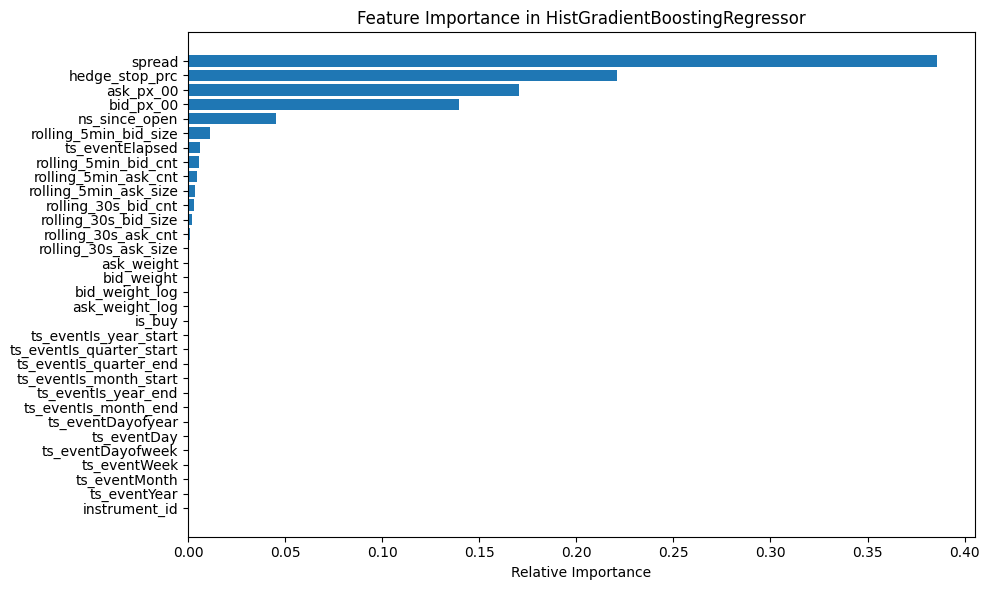

In [124]:
# Get feature importances
importances = est.feature_importances_

# Get feature names if available
feature_names = getattr(x, "columns", [f"Feature {i}" for i in range(x.shape[1])])

# Sort features by importance
indices = np.argsort(importances)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.title("Feature Importance in HistGradientBoostingRegressor")
plt.tight_layout()
plt.show()

In [ ]:
type(to)
to.train.xs.ts_eventIs_quarter_start.unique()
to.train.xs.shape, to.valid.xs.shape
to.valid.xs.head(10)

,instrument_id,symbol,ts_eventYear,ts_eventMonth,ts_eventWeek,ts_eventDay,ts_eventDayofweek,ts_eventDayofyear,ts_eventIs_month_end,ts_eventIs_month_start,...,bid_weight_log,ask_weight_log,rolling_30s_bid_size,rolling_30s_ask_size,rolling_30s_bid_cnt,rolling_30s_ask_cnt,rolling_5min_bid_size,rolling_5min_ask_size,rolling_5min_bid_cnt,rolling_5min_ask_cnt
419,1,1,1,1,1,1,1,1,1,1,...,0.989316,-0.929643,-0.598467,-0.972831,-0.740311,-0.966506,-1.166131,-0.380371,-1.216715,-0.631056
8058,1,1,1,1,1,1,1,1,1,1,...,0.531724,-0.319442,-0.411706,1.058706,-0.513813,0.643564,0.309216,1.851080,0.591268,1.777178
5277,1,1,1,1,1,1,1,1,1,1,...,-0.277267,1.514075,-0.221419,-1.252122,-0.330996,-1.267519,0.009125,1.299003,0.188605,1.221509
9786,1,1,1,1,1,1,1,1,1,1,...,0.198180,-0.135618,-0.150224,-1.440153,-0.347175,-1.701537,-1.097669,-0.698937,-1.168271,-0.703666
4669,1,1,1,1,1,1,1,1,1,1,...,0.828630,0.239296,-0.388763,-0.693851,-0.447481,-1.141513,0.326920,1.747370,0.596157,1.649102
9372,1,1,1,1,1,1,1,1,1,1,...,0.113656,-0.212510,-0.494273,-0.618461,-0.481456,-0.854501,-0.850118,0.865550,-0.739386,0.520620
8853,1,1,1,1,1,1,1,1,1,1,...,-0.339624,-0.495840,-0.510098,0.265641,-0.597941,0.482557,-0.396322,-1.231970,-0.335835,-0.816615
5874,1,1,1,1,1,1,1,1,1,1,...,-2.113849,-0.468058,2.030004,0.454517,2.843215,1.378596,-0.440604,-1.199216,-0.572277,-1.987452
3138,1,1,1,1,1,1,1,1,1,1,...,-0.958099,-1.153927,0.036587,-0.862679,-0.161123,1.140586,0.724039,0.546168,1.109485,0.583146
1160,1,1,1,1,1,1,1,1,1,1,...,2.629162,-0.349639,-0.486957,0.663796,-0.418360,0.384553,-0.805086,1.155745,-0.706498,0.753578
